# Final graded assignment: 
# _Input-output properties of a layer 4 pyramidal cell_

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

Using techniques from the previous week 6 exercise on the Layer 5 pyramidal cell from the NMC portal, in this assignment you will simulate a layer 4 pyramidal cell from the NMC portal under several input configurations, and assess its output.

Let's begin with installing and importing the required Python packages

In [1]:
!pip install --user -q bluepyopt==1.5.12 matplotlib==2.0.2 numpy==1.13.0 2>&1 | grep -v 'SNIMissingWarning\|InsecurePlatformWarning'
!pip install --user -q neurom
!pip install --user -q log_progress

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from log_progress import log_progress

import os
os.unsetenv('PYTHONHOME') # Solve an issue with NEURON simulator import
import zipfile # Extract zip files
import urllib # Download files from the web
import neurom # Analyse / view morphologies
import neurom.viewer

## Downloading the model

As in the Week 6 Tutorial, let's download a Neocortical Layer 4 Pyramidal cell model from the NMC Portal:

In [3]:
urllib.urlretrieve('https://bbp.epfl.ch/nmc-portal/documents/10184/1921829/L4_PC_cADpyr230_2.zip/db6924e5-82ba-4d2c-a5f2-a9f17b8808bf','L4_PC_cADpyr230_2.zip');

Then we extract this zip file on disk:

In [4]:
import os, zipfile
with zipfile.ZipFile('L4_PC_cADpyr230_2.zip', 'r') as zip_file:
    zip_file.extractall('.')

Now we change directory to the model dir. (**Be careful**, once this line is executed don't execute the lines above because it will create nested subdirectories)

In [5]:
os.chdir('L4_PC_cADpyr230_2')

The model contains MOD files describing the NEURON simulator mechanisms used in the model. Compile these files using the 'nrnivmodl' command:

In [6]:
!nrnivmodl mechanisms

/home/jovyan/L4_PC_cADpyr230_2
mechanisms/CaDynamics_E2.mod mechanisms/Ca_HVA.mod mechanisms/Ca_LVAst.mod mechanisms/Ih.mod mechanisms/Im.mod mechanisms/K_Pst.mod mechanisms/K_Tst.mod mechanisms/NaTa_t.mod mechanisms/NaTs2_t.mod mechanisms/Nap_Et2.mod mechanisms/ProbAMPANMDA_EMS.mod mechanisms/ProbGABAAB_EMS.mod mechanisms/SK_E2.mod mechanisms/SKv3_1.mod
CaDynamics_E2.mod Ca_HVA.mod Ca_LVAst.mod Ih.mod Im.mod K_Pst.mod K_Tst.mod NaTa_t.mod NaTs2_t.mod Nap_Et2.mod ProbAMPANMDA_EMS.mod ProbGABAAB_EMS.mod SK_E2.mod SKv3_1.mod
"/usr/local/nrn/x86_64/bin/nocmodl" CaDynamics_E2
Translating CaDynamics_E2.mod into CaDynamics_E2.c
Thread Safe
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -g -O2 -c -o CaDynamics_E2.lo `test -f 'CaDynamics_E2.c' || echo '/'`CaDynamics_E2.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -g -O2 -c CaD

libtool: link: rm -fr  .libs/libnrnmech.la .libs/libnrnmech.lai .libs/libnrnmech.so .libs/libnrnmech.so.0 .libs/libnrnmech.so.0.0.0
libtool: link: gcc -shared  -fPIC -DPIC  .libs/CaDynamics_E2.o .libs/Ca_HVA.o .libs/Ca_LVAst.o .libs/Ih.o .libs/Im.o .libs/K_Pst.o .libs/K_Tst.o .libs/NaTa_t.o .libs/NaTs2_t.o .libs/Nap_Et2.o .libs/ProbAMPANMDA_EMS.o .libs/ProbGABAAB_EMS.o .libs/SK_E2.o .libs/SKv3_1.o .libs/mod_func.o   -Wl,-rpath -Wl,/usr/local/nrn/x86_64/lib -Wl,-rpath -Wl,/usr/local/nrn/x86_64/lib -L/usr/local/nrn/x86_64/lib /usr/local/nrn/x86_64/lib/libnrnoc.so /usr/local/nrn/x86_64/lib/liboc.so /usr/local/nrn/x86_64/lib/libmemacs.so /usr/local/nrn/x86_64/lib/libscopmath.so /usr/local/nrn/x86_64/lib/libsparse13.so /usr/local/nrn/x86_64/lib/libreadline.so -lncurses /usr/local/nrn/x86_64/lib/libnrniv.so /usr/local/nrn/x86_64/lib/libivoc.so /usr/local/nrn/x86_64/lib/libneuron_gnu.so /usr/local/nrn/x86_64/lib/libmeschach.so /usr/local/nrn/x86_64/lib/libsundials.so -lm -ldl  -O2   -pthread 

## Visualizing the morphology

The morphology of the cell is located in the 'morphology' subdirectory. 
We can visualize this morphology using NeuroM:

/opt/conda/envs/python2/lib/python2.7/site-packages/neurom/io/neurolucida.py:263: UserWarning: This is an experimental reader. There are no guarantees regarding ability to parse Neurolucida .asc files or correctness of output.
  warnings.warn(msg)


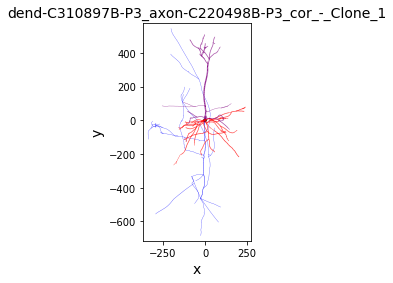

In [7]:
neurom.viewer.draw(neurom.load_neuron('morphology/dend-C310897B-P3_axon-C220498B-P3_cor_-_Clone_1.asc'));

## Initializing the model

To load the functionality of the electrical model we load the 'init.hoc' HOC file.

In [8]:
import neuron as nrn # NEURON simulator
nrn.h.load_file("./init.hoc");

The init.hoc has created a function 'create_cell' to instantiate the neuron in the NEURON simulator. As argument it takes a value to enable/disable the synapses of the cell. (1=True, 0=False)

In [9]:
nrn.h.create_cell(1); # argument 1 stands for 'load synapses'

After this function has been called the global name space of the NEURON simulator contains a variable 'cell'. 
Let's create a python variable to point to this object and for the soma:

In [10]:
cell = nrn.h.cell
soma = cell.soma[0]

## Injecting a step current

Now that we have a pointer to the soma of the neuron, we can inject a current into it. As we've learned in another tutorial, we can create an IClamp to inject the current:

In [46]:
stimulus = nrn.h.IClamp(0.5, sec=soma)

In [47]:
stimulus.dur = 100000 # ms
stimulus.delay = 100  # ms     

As in the tutorial, let's retrieve the holding and step currents from a file in the model package:

In [48]:
with open('current_amps.dat') as current_file:
    current_content = current_file.read()

print 'File content: ', current_content
holding_current, step1_current, step2_current, step3_current = [float(x) for x in current_content.split()]

print
print 'Holding current: %f nA' % holding_current
print 'Step 1: %f nA' % step1_current
print 'Step 2: %f nA' % step2_current
print 'Step 3: %f nA' % step3_current

File content:  -0.084351 0.2106096 0.2281604 0.2457112

Holding current: -0.084351 nA
Step 1: 0.210610 nA
Step 2: 0.228160 nA
Step 3: 0.245711 nA


The 'holding current' is the current the experimentalists inject during the entire recording to hold the neuron at a predefined voltage before the actual stimulus is applied.

The init.hoc also has provided us with a function to enable the recording of the voltage:

In [49]:
nrn.h.create_recording();    #activate recording of activity 

In what follows, we will run some fairly long simulations.
Let's define a function to run simulations with a progress bar:

In [50]:
def run_progressbar(tstop=600):
    # make windows approimately 50ms long
    num_windows = int(float(tstop)/50)
    if num_windows<10:
        num_windows=10
    windows = numpy.linspace(0,tstop,num_windows)
    for nrn.h.tstop in log_progress(windows[1:], every=1):
        if nrn.h.tstop==windows[1]:
            # first run
            nrn.h.run()
        else:
            nrn.h.continuerun(nrn.h.tstop)

... and define a convenience function to simulate and plot

In [65]:
time = nrn.h.time
voltage = nrn.h.voltage

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

time_list=[]
voltage_list=[]

def run_plot(tstop=600):
    nrn.h.dt = 0.05
    time_list.append(numpy.array(time))
    voltage_list.append(numpy.array(voltage))
    run_progressbar(tstop)
    nrn.h.save_recording()

    plot_tv(time, voltage)

In [58]:
time = nrn.h.time
voltage = nrn.h.voltage

def plot_tv(time_array, voltage_array, show=True, label=None, constants=[]):
    plt.plot(time_array, voltage_array, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane voltage (mV)')
    if show:
        plt.show()

time_list=[]
voltage_list=[]

def run_plot(tstop=600):
    nrn.h.dt = 0.05
    run_progressbar(tstop)
    nrn.h.save_recording()

    plot_tv(time, voltage)

First let's stimulate the cell with the first step current protocol

VBox(children=(HTML(value=u''), IntProgress(value=0, max=199)))

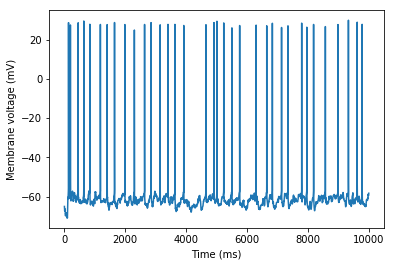

In [66]:
stimulus.amp = holding_current + step1_current
run_plot(10000)

## Exercise Question 1
Using a threshold of 0mV, detect the spike times in the voltage train.  Throw away spike times less that 1s, as they represent a transient phase where the system relaxes from its initial conditions.  Compute the time intervals between subsequent spikes, known as the inter-spike intervals (ISI).  That is, if $t_i$ are the spike times, then $ISI_i=t_{i+1}-t_i$.  This offset subtraction can be compactly represented using numpy indexing of the form `y = x[1:] - x[:-1]`.  Try it out!  

Plot the histogram of ISIs for your spike dataset. How does it look? A Poisson process has an exponential ISI distribution, and a coefficient of variation (CV; see week 4) of 1.  Spiking more "regular" than Poisson will have a CV less than 1.  Spiking more "irregular" than Poisson will have a CV greater than 1.  Compute the CV for your simulation, and add it to an **ans** dictionary as a string or float with key "Q1".

In [77]:
print "Number of synapses: ", len(list(cell.synapses.synapse_list))
print "Number of pre-synaptic cells: ", len(list(cell.synapses.netstim_list))

print (voltage_list[0])
print (time_list[0])

isi=time_list[0][1:] - time_list[0][:-1]

print (isi)
print (v)

print(len(isi))
print(len(time_list[0]))

print(numpy.min(v))

# # p = 0.5 # dynamic p (for the 1st PSP in the train, we have p = U1).
# # n = 10 # number of spikes

# CV_Spikes_Binomial = ((1-p)/(n*p))**(0.5)
# print CV_Spikes_Binomial


Number of synapses:  780
Number of pre-synaptic cells:  204
[-65.         -65.03684712 -65.06412284 ..., -65.43072244 -65.44216007
 -65.45356425]
[  0.00000000e+00   1.00000000e-01   1.75000000e-01 ...,   9.99977500e+03
   9.99987500e+03   9.99997500e+03]
[ 0.1    0.075  0.1   ...,  0.1    0.1    0.1  ]
[-0.03684712 -0.02727572 -0.02474026 ..., -0.01144873 -0.01143763
 -0.01140418]
100000
100001
-9.11713406809


In [90]:
v_list=[]
t_list=[]
for i in range(len(voltage_list[0])):
    if time_list[0][i]>=1000 and voltage_list[0][i]>0: 
        t_list.append(time_list[0][i])
        v_list.append(voltage_list[0][i])
        
t_list = numpy.array(t_list)
v_list = numpy.array(v_list)
isi= t_list[1:] - t_list[:-1]

print(isi)
print(len(isi))

[  1.00000000e-01   1.00000000e-01   1.00000000e-01   1.00000000e-01
   9.89000000e+01   1.00000000e-01   1.00000000e-01   1.00000000e-01
   1.00000000e-01   6.37100000e+02   1.00000000e-01   1.00000000e-01
   1.00000000e-01   1.00000000e-01   2.18100000e+02   1.00000000e-01
   1.00000000e-01   1.00000000e-01   1.00000000e-01   2.67000000e+02
   1.00000000e-01   1.00000000e-01   1.00000000e-01   1.00000000e-01
   2.44725000e+02   1.00000000e-01   1.00000000e-01   1.00000000e-01
   1.00000000e-01   3.25200000e+02   1.00000000e-01   1.00000000e-01
   1.00000000e-01   1.00000000e-01   2.09200000e+02   1.00000000e-01
   1.00000000e-01   1.00000000e-01   1.00000000e-01   3.52700000e+02
   1.00000000e-01   1.00000000e-01   1.00000000e-01   1.00000000e-01
   4.26500000e+02   1.00000000e-01   1.00000000e-01   1.00000000e-01
   1.00000000e-01   1.28700000e+02   1.00000000e-01   1.00000000e-01
   1.00000000e-01   1.00000000e-01   3.52000000e+02   1.00000000e-01
   1.00000000e-01   1.00000000e-01

In [94]:
p = 0.5 # dynamic p (for the 1st PSP in the train, we have p = U1).
n = len(isi) # number of spikes

CV_isi_Binomial = ((1-p)/(n*p))**0.5
print CV_isi_Binomial

0.0808452083454


In [96]:
ans = {}
ans["Q1"] = "0.0808452083454"

## Activating synapses
Now let's define an _in vivo_-like stimulus, where input neurons are firing like Poisson processes with presynaptic morphology type (mtype) specific rates.  

Following the tutorial, load and build the mtype id map:

In [18]:
with open('synapses/mtype_map.tsv') as mtype_map_file:
    mtype_map_content = mtype_map_file.read()
    
mtype_map = {}
for line in mtype_map_content.split('\n')[:-1]:
    n, mtype = line.split()
    mtype_map[mtype] = int(n)
    
print mtype_map

{'L4_ChC': 27, 'L4_LBC': 24, 'L4_NGC': 23, 'L4_SS': 18, 'L4_SBC': 26, 'L5_NGC': 36, 'L4_SP': 17, 'L6_TPC_L4': 42, 'L5_DBC': 34, 'L5_BTC': 33, 'L23_PC': 6, 'L4_BP': 22, 'L5_MC': 32, 'L6_LBC': 51, 'L4_NBC': 25, 'L1_DLAC': 4, 'L23_LBC': 12, 'L5_UTPC': 30, 'L5_STPC': 31, 'L4_BTC': 20, 'L23_NBC': 13, 'L23_SBC': 14, 'L5_ChC': 40, 'L1_NGC-SA': 2, 'L23_MC': 7, 'L1_DAC': 0, 'L6_ChC': 54, 'L4_MC': 19, 'L5_BP': 35, 'L5_LBC': 37, 'L6_NGC': 50, 'L4_DBC': 21, 'L5_SBC': 39, 'L4_PC': 16, 'L23_ChC': 15, 'L6_SBC': 53, 'L6_IPC': 44, 'L6_MC': 46, 'L6_UTPC': 43, 'L5_TTPC1': 28, 'L1_NGC-DA': 1, 'L5_TTPC2': 29, 'L6_DBC': 48, 'L23_DBC': 9, 'L23_BP': 10, 'L5_NBC': 38, 'L6_NBC': 52, 'L1_HAC': 3, 'L23_NGC': 11, 'L6_TPC_L1': 41, 'L6_BPC': 45, 'L1_SLAC': 5, 'L23_BTC': 8, 'L6_BTC': 47, 'L6_BP': 49}


Now, following the tutorial, we will enable all the synapses that are projected onto this cell from all mtypes.
To this end we will define, as before, the init_synapses function:

In [19]:
def init_synapses(enabled_mtypes=[]):
    """Enable all the synapses that are projected onto this cell from mtype listed in enabled_mtypes."""
    enabled_mtype_ints = [mtype_map[mtype] for mtype in enabled_mtypes]
    
    for i in range(0, int(cell.synapses.n_of_mtypes)): # Loop over all the m-type
        if i in enabled_mtype_ints: # Enable synapses
            #  The [were_]active_pre_mtypes is a NEURON vector 
            # (it uses the .x syntax to access the elements)
            # When the value in the vector is 1 all the presynaptic neurons
            # of a particular m-types are active (and inactive when it is 0)
            cell.synapses.were_active_pre_mtypes.x[i]= 0
            cell.synapses.active_pre_mtypes.x[i] = 1        
        else: # Disable synapses
            cell.synapses.were_active_pre_mtypes.x[i]= 1
            cell.synapses.active_pre_mtypes.x[i] = 0
            
    cell.synapses.update_synapses(nrn.h.synapse_plot); # Update the synapses


In [20]:
# Enable incoming synapses from all mtypes
init_synapses(enabled_mtypes=mtype_map.keys())

In [21]:
# The in vivo fluctation driven regime: 
# Depolarize at approx. 100%
# firing times are determined by synaptic drive "fluctuations"
stimulus.amp = holding_current + (step1_current/1.2) # inject the 100% threshold
stimulus.dur = 100000 # keep it on

Each of the synapses is driven by a Poisson process with a firing rate that can be configured for each presynaptic mtype.  Let's configure mtype specific firing rates as described in [Gentet et al., 2010](http://www.sciencedirect.com/science/article/pii/S0896627310000115) for awake conditions, i.e. about 1 Hz for excitatory cells, and 5.0 Hz for inhibitory cells.

In [22]:
exc_cells = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
for mtype in mtype_map:
    if mtype in exc_cells:
        freq = 1.0 # [Hz]
    else:
        freq = 5.0 # [Hz]
    cell.synapses.pre_mtype_freqs.x[mtype_map[mtype]]=freq
    
cell.synapses.update_synapses(nrn.h.synapse_plot);

Now run 100s of simulation, to collect ample statistics.  Note: this will take about 10 minutes to complete.

VBox(children=(HTML(value=u''), IntProgress(value=0, max=1999)))

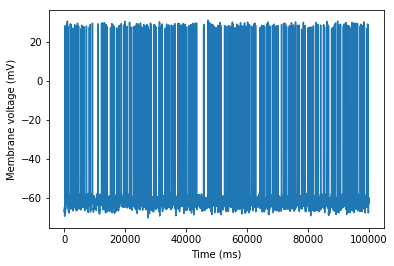

In [23]:
run_plot(100000)

## Exercise Question 2
As in **Question 1**, plot the histogram of ISIs of your spike dataset for this _in vivo_-like stimulation.  How does it look? Compute the CV.  A Poisson process has an exponential ISI distribution, and a coefficient of variation (CV; see week 4) of 1.  Add your answer to the ans dictionary as a string or float with key "Q2". 

In [ ]:
ans["Q2"]=cv

## Statistical models for neuronal firing

The gamma process, with ISI statistics governed by a gamma probability distribution function (PDF) or gamma distribution, is often used to describe the ISI statistics of neuronal firing.  The gamma distribution has two parameters, shape and scale, which parameterize the distribution as described [here](https://en.wikipedia.org/wiki/Gamma_distribution).  The shape and scale parameters uniquely determine the mean and standard deviation of the distribution and vice versa: $\mu=k\theta$, $\sigma=\sqrt{k\theta^2}$, where $\mu$ and $\sigma$ are the mean and standard deviation, and $k$ and $\theta$ are the shape and scale parameters, respectively.  

The various stats of the [gamma process](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) are available in scipy:


In [32]:
from scipy.stats import gamma

The gamma process provided by scipy has an additional parameter, loc (which stands for location), which implements a translation of the PDF along the x-axis.  This can be used to describe  neurons which exhibit a refractory period, a time interval following a spike for which spiking is forbidden. 

Assuming your inter-spike interval data are stored in the variable `isi`,
the following command can be used to fit a gamma distribution to your ISI data:

`shape, loc, scale = gamma.fit(isi)`

For a pure gamma distribution, one must force a zero refractory period, i.e. loc=0, for the fit as follows:


In [33]:
shape, loc, scale = gamma.fit(isi, floc=0)
print shape
print scale

NameError: name 'isi' is not defined

In [ ]:
# For the gamma distribution, shape and scale can also be computed from mean and variance 
shape2 = numpy.mean(isi)**2/numpy.var(isi)
print shape2
scale2 = numpy.var(isi)/numpy.mean(isi)
print scale2

Now, lets compare our fit to a histogram of our ISI data, to visually inspect how well the gamma process describes the firing of our model neuron.

In [ ]:
# The 'denstity' kwarg results in a pdf, i.e. its normalized to 1
# so it can be directly compared to gamma.pdf 
h1, bins = numpy.histogram(isi, bins=50, density=True);
# append a zero bin at the end to make same dimensions as bins (for plotting)
h1 = numpy.hstack((h1, 0))

In [ ]:
plt.plot(bins, h1, ls="steps-post")
x = numpy.arange(0,1000,0.5)
plt.plot(x, gamma.pdf(x, a=shape, loc=loc, scale=scale))

## Exercise Question 3
Following the development above, fit a gamma process with refractory period (loc>=0) to your isi data.  From visual inspection, does the additional refractory period parameter make much difference in describing your isi data for short isi intervals?  Submit your resulting shape, loc, scale fits as follows: 

In [ ]:
ans["Q3"]=(shape, loc, scale)

## ISI Correlations

The gamma process is a special case of a renewal process, and as such, subsequent ISIs are statistically independent.  By contrast, neuronal ISIs are generally negatively correlated, as a result of [spike frequency adaptation](http://www.scholarpedia.org/article/Spike_frequency_adaptation) due to spike activated $K^+$ channels such as the [M-current](http://channelpedia.epfl.ch/ionchannels/26). Let's investigate this concept more closely.

To begin, let's generate some ISIs for our fitted gamma process, and plot a scatter plot of $ISI_{i+1}$ vs $ISI_i$.  To this end, the `gamma.rvs` can generate these "random variates" according to the parameters we fit previously.

In [ ]:
gamma_isi = gamma.rvs(size=isi.shape, a=shape, loc=loc, scale=scale)

In [ ]:
plt.plot(gamma_isi[:-1], gamma_isi[1:], '.')
plt.xlabel('$ISI_i$ [ms]', fontsize=16)
plt.ylabel('$ISI_{i+1}$ [ms]', fontsize=16)

We can assess if subsequent ISIs of the gamma process are correlated using a linear regression:

In [ ]:
from scipy.stats import linregress

In [ ]:
slope, intercept, r_value, p_value, std_err = linregress(gamma_isi[:-1], gamma_isi[1:])

In [ ]:
r_value, p_value 

As described [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.linregress.html), the r_value is the correlation coefficient, and the p_value is for the test of the null hypothesis (no correlation).  We find an r_value close to zero, and a high p_value indicating we cannot reject the null hypothesis that subsequent ISIs are uncorrelated.  Indeed they ISIs are uncorrelated by definition for the gamma process.

Let's plot the result of the linear regression:

In [ ]:
plt.plot(gamma_isi[:-1], gamma_isi[1:], '.')
plt.plot(bins, slope*bins+intercept, 'r-')

Let's now generate the scatter plot for our simulated neuronal ISI data

In [ ]:
plt.plot(isi[:-1], isi[1:], '.')
plt.xlabel('$ISI_i$ [ms]', fontsize=16)
plt.ylabel('$ISI_{i+1}$ [ms]', fontsize=16)

We get a clear picture that long ISIs ($>500$ ms) are followed by short ISIs ($<300$ ms), whereas short ISIs ($<300$ ms) are followed by the longest ISIs, sometimes $>700$ ms.  This suggests that subequent ISIs are negatively correlated.  We can again investigate this correlation more quantitatively using linear regression.

## Exercise Question 4
Undertake a similar analysis as above for your simulated neuronal ISIs.  Perform a linear regression on subsequent ISIs.  Submit your r_value and p_value for your neuronal ISI data as follows.  Consider the result: Does linear regression reveal a statistically significant negative correlation, as expected?  

In [ ]:
ans["Q4"]=(r_value, p_value)

## Submit you answers
Print your **ans** dictionary as a json string, and submit the string to the course platform by executing the submission code below.  You will also need a submission key from the course platform. 

In [ ]:
import json; print json.dumps(ans)

In [ ]:
# Install the grader client
import os; os.unsetenv('PYTHONHOME')
!pip -q install --force-reinstall --upgrade --pre -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client 2>&1 | grep -v -e 'SNIMissingWarning' -e 'InsecurePlatformWarning'  

In [ ]:
# Submit your answer.  The submission key can be retrieved from the edX platform
import single_cell_mooc_client as sc_mc
submission_widget = sc_mc.Submission()